In [73]:
import pandas as pd
df = pd.read_csv("wine_processed.csv")

In [74]:
df.head(2)

,keyword,price,产区,原产地,口感,国产/进口,特性,甜度,颜色,冰酒/贵腐/甜酒,...,长相思（Sauvignon Blanc）,内比奥罗（Nebbiolo）,佳美（Gamay）,品丽珠（Cabernet Franc）,匹诺塔吉（Pinotage）,霞多丽（Chardonnay）,蛇龙珠（Cabernet Gernischt）,佳美娜（Carmenere）,year,alcohol
0,通化/tonghua,0-50,其它,法国,饱满,进口,普通餐酒,半干型,宝石红,0,...,0,0,0,0,0,0,0,0,99999,12.0
1,长城/greatwall,0-50,其它,中国,柔和,国产,普通餐酒,干型,宝石红,0,...,0,0,0,0,0,0,0,0,99999,12.0


In [75]:
df.groupby("price").size()

price
0-50                        1842
100-150                     1425
1000-2000                    226
150-250                     1699
2000-9223372036854775807     414
250-500                     1590
50-100                      3029
500-1000                     726
dtype: int64

In [76]:
# 平衡数据
tmp1 = df[df.price=='1000-2000']
tmp2 = df[df.price=='2000-9223372036854775807']
tmp3 = df[df.price=='500-1000']
for i in range(6):
    df = df.append(tmp1, ignore_index=True)
for j in range(3):
    df = df.append(tmp2,ignore_index=True)
df = df.append(tmp3,ignore_index=True)

## 剔除50-100的一半数据
tmp4 = df[df.price=='50-100']
df = df[df.price!='50-100']
df = df.append(tmp4[::2],ignore_index=True)

print(df.groupby("price").size())

price
0-50                        1842
100-150                     1425
1000-2000                   1582
150-250                     1699
2000-9223372036854775807    1656
250-500                     1590
50-100                      1515
500-1000                    1452
dtype: int64


In [77]:
# 划分X,Y
X = df[df.columns.difference(['price'])]      
Y = df['price']
print(X.shape)
print(Y.shape)

(12761, 33)
(12761,)


In [78]:
# 对非字符型特征进行数值编码
# X = pd.get_dummies(X)        #onehot编码
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
features = [col for col in X.columns.values if X[col].dtype == "object"]         #筛选出object类型的特征
encoders = dict()
for f in features:
    cc = le.fit(X[f])
    encoders[f] = cc.classes_
    X[f] = cc.transform(X[f])
#     X[f] = le.fit_transform(X[f])

# 保存字符转换的规则
import pickle
with open("encoders.dict", "wb") as f:
    pickle.dump(encoders, f)

/usr/local/python3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [79]:
X.dtypes

alcohol                    float64
keyword                      int64
year                         int64
产区                           int64
仙粉黛（Zinfandel）               int64
佳美娜（Carmenere）               int64
佳美（Gamay）                    int64
其它                           int64
内比奥罗（Nebbiolo）               int64
冰酒/贵腐/甜酒                     int64
匹诺塔吉（Pinotage）               int64
原产地                          int64
口感                           int64
品丽珠（Cabernet Franc）          int64
国产/进口                        int64
果味葡萄酒                        int64
桃红葡萄酒                        int64
桑娇维塞（Sangiovese）             int64
梅洛（Merlot）                   int64
特性                           int64
甜度                           int64
白葡萄酒                         int64
红葡萄酒                         int64
蛇龙珠（Cabernet Gernischt）      int64
西拉/设拉子（Syrah/Shiraz）         int64
赤霞珠（Cabernet Sauvignon）      int64
起泡酒/香槟                       int64
长相思（Sauvignon Blanc）         int64
雷司令（Riesling）       

In [80]:
from sklearn.model_selection import train_test_split  

# 划分数据训练集，测试集
# 80%训练集，20%的测试集；为了复现实验，设置一个随机数,划分结果是确定的
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42 )  

# 模型相关（载入模型--训练模型--模型预测）
from xgboost import XGBClassifier
model = XGBClassifier(learning_rate=0.25, n_estimators=100, objective= "multi:softmax", num_class=8, max_depth=12, subsample =0.95)
model.fit(x_train,y_train)            # 训练模型（训练集）
y_pred = model.predict(x_test)        # 模型预测（测试集），y_pred为预测结果

# 性能评估
from sklearn.metrics import accuracy_score   # 准确率
accuracy = accuracy_score(y_test,y_pred)
print("accuarcy: %.2f%%" % (accuracy*100.0))

from sklearn.metrics import  classification_report
#输出详细的分类性能
print(classification_report(y_pred,y_test,target_names=['0-50','50-100','100-150','150-250','250-500','500-1000','1000-2000','2000-sys.maxsize']))

accuarcy: 68.31%
                  precision    recall  f1-score   support

            0-50       0.77      0.67      0.72       439
          50-100       0.51      0.53      0.52       266
         100-150       0.98      0.90      0.94       369
         150-250       0.55      0.59      0.57       324
         250-500       0.96      0.94      0.95       313
        500-1000       0.51      0.56      0.53       285
       1000-2000       0.37      0.41      0.39       249
2000-sys.maxsize       0.76      0.73      0.75       308

       micro avg       0.68      0.68      0.68      2553
       macro avg       0.67      0.67      0.67      2553
    weighted avg       0.70      0.68      0.69      2553



In [81]:
label = pd.DataFrame(y_test,columns=["price"])
label.groupby("price").size()

price
0-50                        383
100-150                     281
1000-2000                   341
150-250                     352
2000-9223372036854775807    308
250-500                     312
50-100                      280
500-1000                    296
dtype: int64

In [82]:
prediction = pd.DataFrame(y_pred,columns=["prediction"])
prediction.groupby("prediction").size()

prediction
0-50                        439
100-150                     266
1000-2000                   369
150-250                     324
2000-9223372036854775807    313
250-500                     285
50-100                      249
500-1000                    308
dtype: int64

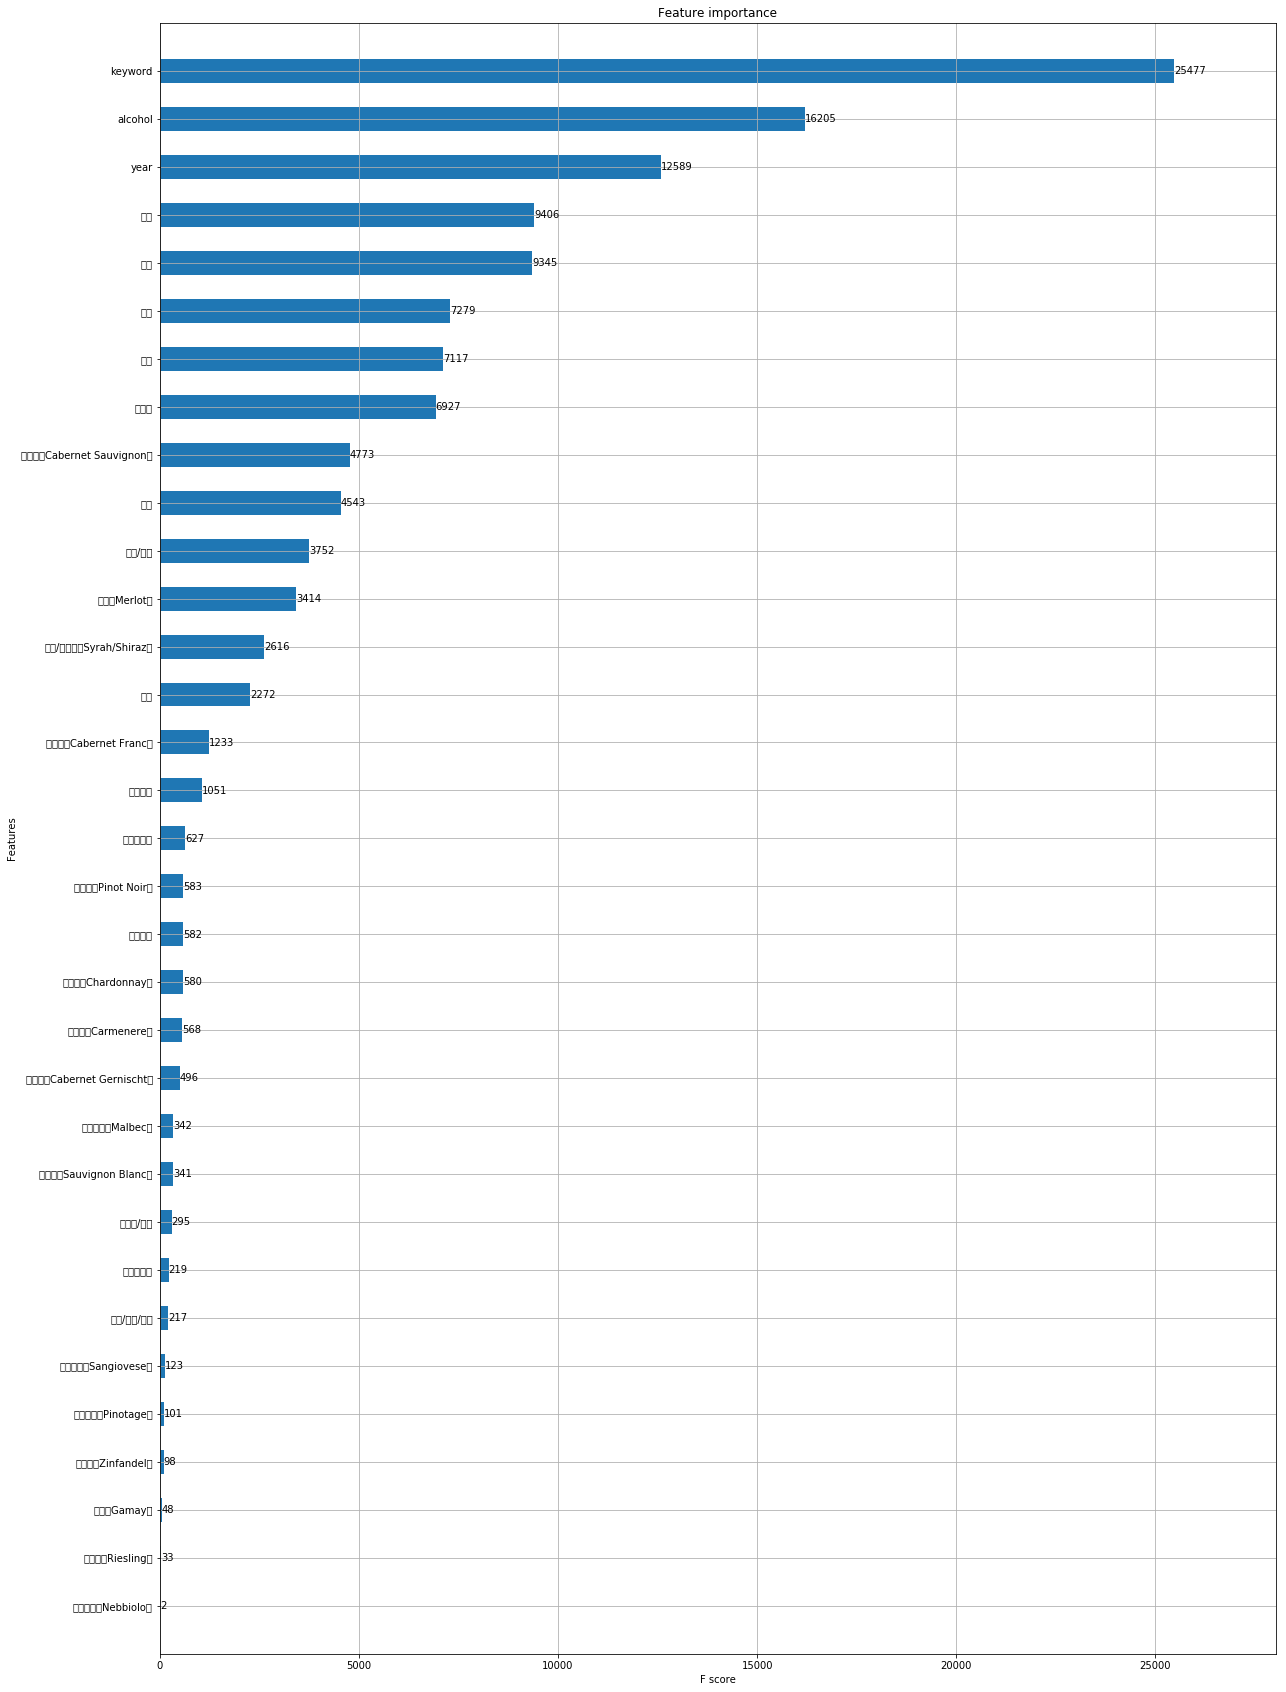

In [83]:
### 特征重要性
from pylab import mpl 
# mpl.rcParams['font.sans-serif'] = ['FangSong'] 

import matplotlib.pyplot as plt
%matplotlib inline
from xgboost import plot_importance
fig,ax = plt.subplots(figsize=(20,30))
plot_importance(model,height=0.5,max_num_features=64,ax=ax)
plt.show()

In [84]:
feature_importance=pd.DataFrame(list(model.get_booster().get_fscore().items()),
columns=['feature','importance']).sort_values('importance', ascending=False)
print('',feature_importance)

                     feature  importance
2                   keyword       25477
1                   alcohol       16205
10                     year       12589
3                        特性        9406
5                        口感        9345
8                        颜色        7279
7                        产区        7117
13                      原产地        6927
4   赤霞珠（Cabernet Sauvignon）        4773
9                        其它        4543
0                     国产/进口        3752
14               梅洛（Merlot）        3414
18     西拉/设拉子（Syrah/Shiraz）        2616
12                       甜度        2272
21      品丽珠（Cabernet Franc）        1233
17                     白葡萄酒        1051
15                    桃红葡萄酒         627
19          黑皮诺（Pinot Noir）         583
11                     红葡萄酒         582
16          霞多丽（Chardonnay）         580
20           佳美娜（Carmenere）         568
6   蛇龙珠（Cabernet Gernischt）         496
24             马尔贝克（Malbec）         342
26     长相思（Sauvignon Blanc）         341

In [85]:
# 掌握特征重要性之后重新再训练
choose = list(feature_importance[feature_importance.importance>400]["feature"])
# 划分X,Y
# X = df[df.columns.difference(['price'])]  
X = df[choose]
Y = df['price']
print(X.shape)
print(Y.shape)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
features = [col for col in X.columns.values if X[col].dtype == "object"]         #筛选出object类型的特征
for f in features:
    X[f] = le.fit_transform(X[f])
    
    
from sklearn.model_selection import train_test_split  

# 划分数据训练集，测试集
# 80%训练集，20%的测试集；为了复现实验，设置一个随机数,划分结果是确定的
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42 )  

# 模型相关（载入模型--训练模型--模型预测）
from xgboost import XGBClassifier
model = XGBClassifier(learning_rate=0.25, n_estimators=100, objective= "multi:softmax", num_class=8, max_depth=12, subsample =0.95)
model.fit(x_train,y_train)            # 训练模型（训练集）
y_pred = model.predict(x_test)        # 模型预测（测试集），y_pred为预测结果

# 性能评估
from sklearn.metrics import accuracy_score   # 准确率
accuracy = accuracy_score(y_test,y_pred)
print("accuarcy: %.2f%%" % (accuracy*100.0))

(12761, 22)
(12761,)


/usr/local/python3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


accuarcy: 68.59%


In [103]:
pickle.dump(model, open("pima.pickle.dat", "wb"))

In [108]:
# 加载模型
import xgboost as xgb
# bst = xgb.Booster({'nthread':4}) #init model
# bst.load_model("xgb1.model") # load data
bst = pickle.load(open("pima.pickle.dat", "rb"))

# 载入测试数据
test_data = df.iloc[[0]]
test = test_data[test_data.columns.difference(['price'])]     
Y = test_data['price']
print("the true result: ",Y[0])

# 转换数据
coders = {}
with open("encoders.dict", "rb") as f:
    coders = pickle.load(f)
aa = LabelEncoder()
for x,y in coders.items():
    aa.classes_ = y
    test[x] = aa.transform(test[x])
print(test)

# 预测
p = bst.predict(test[choose])
print("the prediction of test: ",p)

the true result:  0-50


/usr/local/python3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


   alcohol  keyword   year  产区  仙粉黛（Zinfandel）  佳美娜（Carmenere）  佳美（Gamay）  其它  \
0     12.0      189  99999   2               0               0          0   1   

   内比奥罗（Nebbiolo）  冰酒/贵腐/甜酒       ...         蛇龙珠（Cabernet Gernischt）  \
0               0         0       ...                               0   

   西拉/设拉子（Syrah/Shiraz）  赤霞珠（Cabernet Sauvignon）  起泡酒/香槟  \
0                     0                        0       0   

   长相思（Sauvignon Blanc）  雷司令（Riesling）  霞多丽（Chardonnay）  颜色  马尔贝克（Malbec）  \
0                     0              0                0   0             0   

   黑皮诺（Pinot Noir）  
0                0  

[1 rows x 33 columns]
the prediction of test:  ['0-50']
